**3장 – 분류**

### import module

In [1]:
import sys
import sklearn
import numpy as np
# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### MNIST

- 데이터 불러오기 
    - mnist.keys()를 통해 데이터와 target이외에도 많은 것들이 있는 것을 확인할 수 있음

In [2]:
# mnist 데이터를 불러옴
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# 데이터를 용도에 맞게 지정
X, y = mnist["data"], mnist["target"] # X가 데이터들, y가 정답 라벨이라고 생각하면 편할듯
y = y.astype(np.uint8) # 확인해보면 y가 문자열로 들어가있음

# 출력하여 데이터의 크기 확인
print(X.shape) # 28*28 = 784 / 즉 모든 픽셀들이 피처로 들어가있음
print(y.shape) # 정답 라벨값

(70000, 784)
(70000,)


- 데이터 확인하기

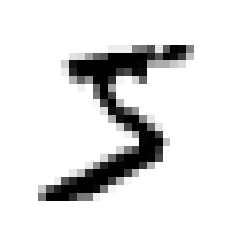

In [3]:
# 이미지를 확인하는 함수를 지정
def plot_digit(data):
    image = data.reshape(28, 28) # 28*28의 형태로 변경해줌
    plt.imshow(image, 
               cmap = mpl.cm.binary, # 색지정
               interpolation="nearest") # 이미지가 잘보이도록 보간
    plt.axis("off") # 그래프로 그릴때 축은 필요가 없으므로 꺼줌

# 이미지 확인
some_digit = X[0] # y[0]을 통해 확인해보면 5임
plot_digit(some_digit)

In [4]:
# 훈련과 검증을 위하여 train과 test로 분리
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

- 이진 분류기 훈련

In [5]:
# 편의상 라벨이 5인 것만 실행하기 위하여 라벨이 5인 것만 뽑아줌. 즉, 숫자 5에 대해서만 진행
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [6]:
# SGD를 활용하여 훈련을 진행 -> 기본 훈련
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42) # 모델 지정
sgd_clf.fit(X_train, y_train_5) # fitting

SGDClassifier(random_state=42)

### 성능 측정

- 교차 검증을 사용한 정확도 측정

In [7]:
# 기본 교차검증
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [8]:
# StratifiedKFold (층화추출)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone # 모델을 복사해주는 함수

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생합니다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정합니다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) # 모델을 복사해줌 copy와 비슷하다고 생각
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


### confusion_matrix

In [9]:
# cross_val_predict
### k겹 교차검증을 수행하지만 평가점수를 반환하는것이 아닌 예측값을 반환 ###
### 훈련하는 동안 보지 못했던 데이터에 대해 예측가능 ###
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [10]:
# confusion_matrix를 직접 눈으로 보고 판단할 수 있음
### 각 클래스별 예측값을 보여줌 (ex:5를 3으로 잘못 예측한 횟수를 알고싶으면 5행 3열을 보면됨.)
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred) # 우리가 알고있는 오차행렬의 원리로 이해하면됨

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

- 정밀도(precision), 재현율(recall)

In [11]:
# sklearn에서 제공하는 함수를 통해 score확인가능
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [12]:
# f1 score또한 확인가능
### 어느곳에 중점을 둘 것이냐에 따라 달라짐
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision & Recall Trade-off

In [13]:
y_scores = sgd_clf.decision_function([some_digit]);y_scores # decision_function함수를 통해 각 샘플의 점수를 확인할 수 있음.

array([2164.22030239])

In [14]:
threshold = 0 # 임계값을 임의로 정할 수 있음 / 이 값을 높이느냐 내리느냐에 따라 True, False가 결정됨
y_some_digit_pred = (y_scores > threshold) # 위에서 구한 점수가 2164.22030239이기 때문에 True출력

- 적절한 임계값 찾기

In [15]:
# cross_val_predict를 활용하여 결정점수를 받을 수 있음
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function") # method를 decision_function로 지정함으로써 결정점수를 받을 수 있음

In [16]:
# 그래프를 통해 적절한 임계값을 찾을 수 있음
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

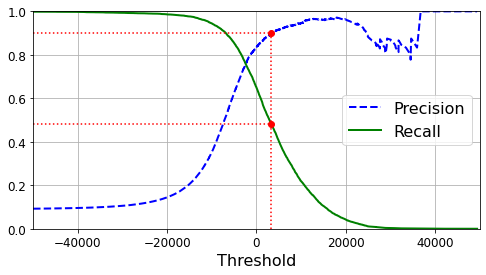

In [19]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                            
    plt.axis([-50000, 50000, 0, 1])             

plt.figure(figsize=(8, 4))                                            
plot_precision_recall_vs_threshold(precisions, recalls, thresholds) # precision과 recall을 그려줌

## 추가적인 그래프 ##
# precision이 90이상 되는 recall, threshold의 값을 찾기 위함 
recall_90_precision = recalls[np.argmax(precisions >= 0.90)] 
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
# 이후부터는 그래프의 빨간실선 부분을 그려줌
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

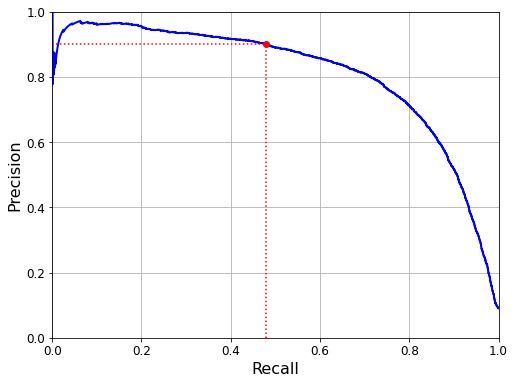

In [20]:
# 재현율에 대한 정밀도 곡선 그래프
## trade off를 선택하는 방법중 하나
## sklearn의 plot_precision_recall 모듈 있음
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

## 추가적인 부분
# 그래프에서 빨간 부분을 그려줌
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

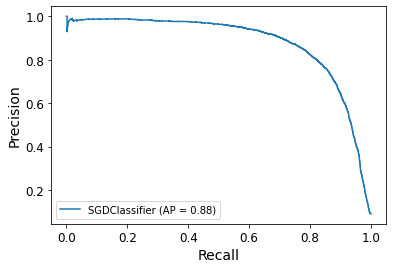

In [31]:
# sklearn의 plot_precision_recall 모듈
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(sgd_clf, X_train, y_train_5)

In [21]:
## thresholds 찾기
# np.argmax(precisions >= 0.90) -> true값들 중 index가 가장 큰 값 / 이 값의 thresholds를 사용
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# 위에서 구한 threshold 보다 큰 값을 찾아줌
y_train_pred_90 = (y_scores >= threshold_90_precision)

# score확인
print(f'\
precision_score: {precision_score(y_train_5, y_train_pred_90)}\n\
recall_score: {recall_score(y_train_5, y_train_pred_90)}')

precision_score: 0.9000345901072293
recall_score: 0.4799852425751706


### ROC 곡선

In [22]:
from sklearn.metrics import roc_curve # 이를 통해 fpr, tpr, thresholds을 알 수 있음

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

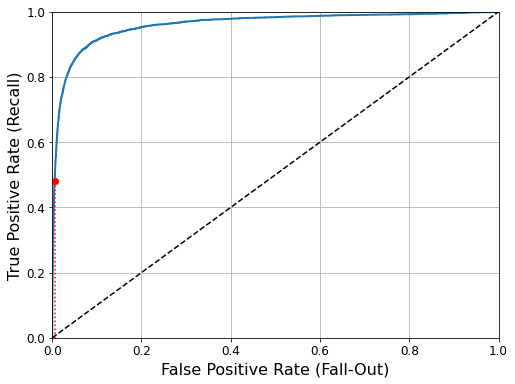

In [23]:
# roc_curve를 그려주는 함수
## sklearn의 plot_roc_curve 모듈 있음
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)   
    plt.grid(True)                                           

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)

## 추가
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
plt.show()

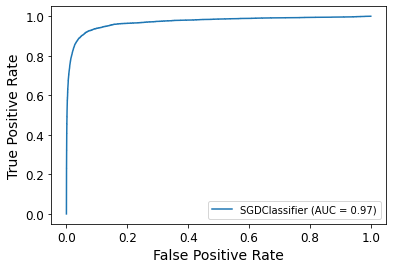

In [32]:
# sklearn의 plot_roc_curve 모듈 -> 훨씬 간단함
from sklearn.metrics import plot_roc_curve

plot_roc_curve(sgd_clf, X_train, y_train_5)

In [24]:
# score 확인
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

    일반적으로 양성 클래스가 드물거나 FN보다 FP이 더 중요한 경우 PR곡선을 사용하고,   
    그렇지 않은경우 ROC곡선을 사용함.  
    ex) roc_auc_score를 보면 좋은 분류기라고 생각할 수 있겠지만 음성(5 아님)에 비해 양성(5)이 매우 적음

- RandomForestClassifier를 통한 비교

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [26]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스(1)의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

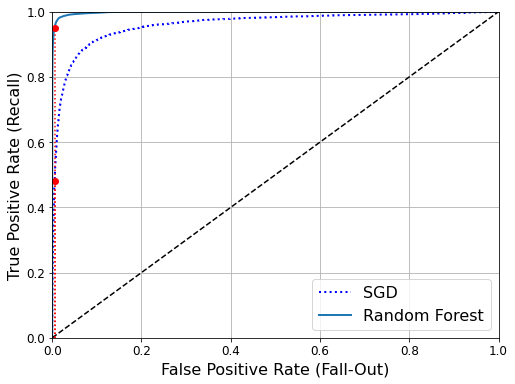

In [27]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

## 추가
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [31]:
# 점수를 보면 랜덤포레스트가 훨씬 좋은 것을 확인할 수 있음
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

# 결과 출력하여 확인
print(f'\
roc_auc_score: {roc_auc_score(y_train_5, y_scores_forest)}\n\
precision_score: {precision_score(y_train_5, y_train_pred_forest)}\n\
recall_score: {recall_score(y_train_5, y_train_pred_forest)}')

roc_auc_score: 0.9983436731328145
precision_score: 0.9905083315756169
recall_score: 0.8662608374838591


### 다중 분류

        OvR (=OvA): 10개의 숫자중에 하나만 분류하는 분류기를 10번 학습시키는 방법  
         -> ex) 5와 5가 아님으로 분류하는 분류기  
          
        OvO: 각 숫자의 조합마다 이진분류기를 훈련

In [32]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train으로 학습
svm_clf.predict([some_digit]) # 위에서 label이 5이던 값을 예측

array([5], dtype=uint8)

In [33]:
some_digit_scores = svm_clf.decision_function([some_digit]);some_digit_scores # decision_function 함수를 통해 각 class의 점수를 확인

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [34]:
# sklearn에서 OvO 혹은 OvR을 사용하도록 강제할 수도 있음
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42)) # OvR을 사용하도록 강제함
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [35]:
# sgd_clf는 SGD로 위에서 설정함
sgd_clf.fit(X_train, y_train) #fit
sgd_clf.decision_function([some_digit]) # 각 class별 점수를 확인할 수 있음

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [37]:
# # 교차검증 점수를 확인해봄 -> 오래걸림
# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [41]:
# scailing을 통해 점수 향상 가능 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy") # -> 오래걸림

### 에러 분석
*좋은 모델을 고른후 모델의 성능을 높이는 방법 중 하나*

In [42]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

사이킷런 0.22 버전부터는 `sklearn.metrics.plot_confusion_matrix()` 함수를 사용할 수 있습니다.

In [43]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

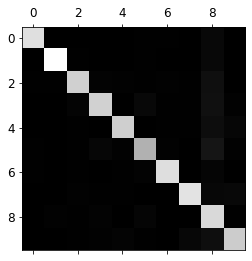

In [53]:
# 오차행렬을 시각화하여 확인 -> 5의 경우 더 색이 어두움 / 잘 못맞춘다는 뜻
## 행은 실제 값 / 열은 예측값임
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [45]:
# 각 클래스별 에러 비율을 구해줌
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

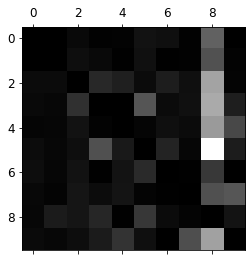

In [55]:
np.fill_diagonal(norm_conf_mx, 0) # 축들을 0으로 채워줌
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

### 다중 레이블 분류

In [57]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # 해당 값이 큰값(7이상)인지
y_train_odd = (y_train % 2 == 1) # 해당 값이 홀수인지
y_multilabel = np.c_[y_train_large, y_train_odd] # np.c_ -> 두개의 1차원 배열을 합쳐서 2차원 배열로 만들어줌 / 즉, y_train을 변경한 것
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

**경고**: 다음 셀은 실행하는데 매우 오래 걸립니다(하드웨어에 따라 몇 시간이 걸릴 수 있습니다).

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3) # 새로운 라벨에 학습을 시킴
f1_score(y_multilabel, y_train_knn_pred, average="macro") # 실제값과 예측값의 f1값을 구함
# -> 이 코드는 모든 레이블의 가중치가 같다고 가정한 것임
# -> 가중치를 주는 방식은 average를 바꾸면 됨.

In [ ]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("정밀도: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("재현율: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

정밀도: 95.88%
재현율: 97.89%
